In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
transform=transforms.ToTensor()

trainset=torchvision.datasets.FashionMNIST(root='./data',train=True,download=True,transform=transform)

testset=torchvision.datasets.FashionMNIST(root='./data',train=False,download=True,transform=transform)

classes=('T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker',
            'Bag','Ankle boot')

100.0%
100.0%
100.0%
100.0%


In [4]:
train_iter=iter(trainset)

image,label=next(train_iter)

image.shape,label

(torch.Size([1, 28, 28]), 9)

Ankle boot


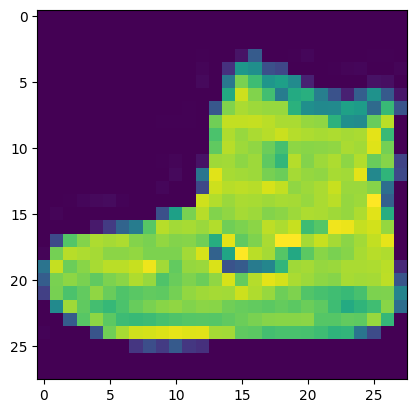

In [6]:
import matplotlib.pyplot as plt
import numpy as np

np_img=image.numpy()
print(classes[label])
plt.imshow(np_img.reshape((28,28,1)))

In [7]:
len(trainset)

60000

In [8]:
len(testset)

10000

In [9]:
 trainset,valset=torch.utils.data.random_split(trainset,[50000,10000])
 len(valset),len(trainset)

(10000, 50000)

In [10]:
batch_size=8

trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

valloader=torch.utils.data.DataLoader(valset,batch_size=batch_size,shuffle=False,num_workers=2)

testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=2)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=256,kernel_size=3)
    self.pool1=nn.MaxPool2d(2,2)

    self.conv2=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
    self.pool2=nn.MaxPool2d(2,2)

    self.conv3=nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=2)
    self.pool3=nn.MaxPool2d(2,2)

    self.flatten=nn.Flatten()

    self.fc1=nn.Linear(in_features=4096,out_features=1024)
    self.drop1=nn.Dropout(p=0.3)

    self.fc2=nn.Linear(in_features=1024,out_features=1024)
    self.drop2=nn.Dropout(p=0.3)

    self.fc3=nn.Linear(in_features=1024,out_features=10)




  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=self.pool1(x)

    x=F.relu(self.conv2(x))
    x=self.pool2(x)

    x=F.relu(self.conv3(x))
    x=self.pool3(x)

    x=self.flatten(x)

    x=F.relu(self.fc1(x))
    x=self.drop1(x)

    x=F.relu(self.fc2(x))
    x=self.drop2(x)

    x=self.fc3(x)

    return x

In [12]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'
net=NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)

In [13]:
for i, data in enumerate(trainloader):
  inputs,label=data[0].to(device),data[1].to(device)
  print(f"input shape:{inputs.shape}")
  print(f"after network :{net(inputs).shape}")
  break

input shape:torch.Size([8, 1, 28, 28])
after network :torch.Size([8, 10])


In [14]:
num_params=0
for x in net.parameters():
  num_params+=len(torch.flatten(x))
print(f"Number of parameters are {num_params:,}")

Number of parameters are 8,536,074


In [15]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.0001)

In [16]:
def train_one_epoch():
  net.train(True)
  running_loss=0.0
  runnning_accuracy=0.0

  for batch_index,data in enumerate(trainloader):
    inputs,labels=data[0].to(device),data[1].to(device)

    optimizer.zero_grad()

    output=net(inputs)

    correct=torch.sum(labels==torch.argmax(output,dim=1)).item()
    runnning_accuracy+=correct/batch_size

    loss=criterion(output,labels)
    running_loss+=loss.item()
    loss.backward()
    optimizer.step()

    if batch_index%500==499:
      avg_loss=running_loss/500
      avg_acc=(runnning_accuracy/500)*100
      print(f" Batch {0}, Loss:{1:.3f}, accuracy :{2:.2f}%%".format(batch_index+1,avg_loss,avg_acc))

      running_loss=0.0
      runnning_accuracy=0.0
    print()

In [17]:
def validate_one_epoch():
  net.train(False)
  running_loss=0.0
  runnning_accuracy=0.0

  for i,data in enumerate(valloader):
    inputs,labels=data[0].to(device),data[1].to(device)

    with torch.no_grad():
      outputs=net(inputs)
      correct=torch.sum(labels==torch.argmax(outputs,dim=1)).item()
      runnning_accuracy+=correct/batch_size
      loss=criterion(outputs,labels)
      running_loss+=loss.item()
    _,predicted = torch.max(outputs.data,1)
  avg_loss=running_loss/len(valloader)
  avg_acc=(runnning_accuracy/len(valloader))*100

  print("Val Loss :{0:.3f}, Val Accuracy {1:.1f}%".format(avg_loss,avg_acc))
  print("---------------------------")
  print()

In [18]:
epochs=10

for i in range(epochs):
  print(f"Epoch: {i+1}")

  train_one_epoch()
  validate_one_epoch()

print(f"Finished Training")

Epoch: 1



















































































































































































































































































































































































































































































































 Batch 0, Loss:1.000, accuracy :2.00%%







































































































































































































































































































































































































































































In [ ]:


def predict(model, dataset, device="cuda"):
    model.eval()  
    predictions = []
    labels = []

    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

    with torch.no_grad():  
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)  
            _, preds = torch.max(outputs, 1)  

            predictions.extend(preds.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return predictions, labels


In [ ]:
image, label = testset[0]
image = image.unsqueeze(0).to(device) 

net.eval()
with torch.no_grad():
    output = net(image)
    predicted_class = torch.argmax(output, dim=1).item()

print("True Label:", label)
print("Predicted Label:", predicted_class)

True Label: 9
Predicted Label: 9


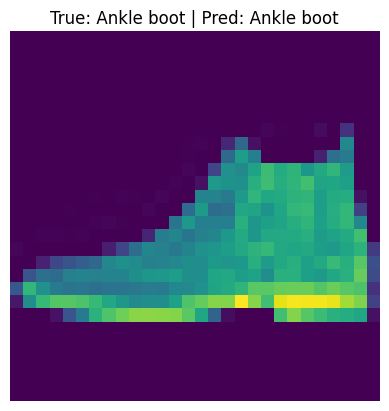

In [29]:
image, label = testset[0]
image_tensor = image.unsqueeze(0).to(device)

import matplotlib.pyplot as plt
import numpy as np
plt.imshow(image.squeeze())
plt.title(f"True: {classes[label]} | Pred: {classes[predicted_class]}")
plt.axis("off")
plt.show()